## CAUTION - DATA LOSS WARNING

"! rm -rf ./*" is used frequently in these notebooks, to clear old datasets, and download fresh copies

This removes all files and dirs in current folder, if you download and run this notebook on your machine

This is safe to use on colab and kaggle since they have temporary file systems

But not safe to run on local systems! Doing so will delete all files in your working directory

## Data Preparation

In [1]:
import gc
import os
import time
import numpy as np
import torch
import random
import torch.nn as nn
import torchvision.transforms.functional as tf

from getpass import getpass
from torchinfo import summary
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision.transforms import Resize, Compose, InterpolationMode

In [2]:
# (repo is outdated, use only for dataset)
# https://github.com/Beckschen/TransUNet
# https://stackoverflow.com/a/39087286
# expect 8 to 10 GB of data after unzip

# https://drive.google.com/drive/folders/1ACJEoTp-uqfFJ73qS3eUObQh52nGuzCd
# ---->    https://drive.google.com/file/d/1BvpY0g9mKkkhdHpAX1HqDw8iTJNbFuwq/view BTCV.zip
# https://drive.google.com/drive/folders/1KQcrci7aKsYZi1hQoZ3T3QUtcy7b--n4
# ---->    https://drive.google.com/file/d/1fiGIevmbfLwvHUblYaDhDdC0aHlt277f/view ACDC.zip
# ---->    https://drive.google.com/file/d/1tGOEhPWYLduEomMbeC3BnF2rLa52GoE2/view temp.zip
! rm -rf ./*

def drivewget(ID, NAME, *, unzip=True):
    os.environ["FILEID"] = ID
    os.environ["FILENAME"] = NAME
    os.environ["UUID"] = getpass("Enter manual UUID:")
    ! mkdir -p ./down
    ! wget -q "https://drive.usercontent.google.com/download?id=$FILEID&export=download&confirm=t&uuid=$UUID" -O ./down/$FILENAME > /dev/null
    ! rm -rf /tmp/cookies.txt
    ! echo -e "downloaded $FILENAME!"
    os.environ["UUID"] = "dummy"

    if (unzip and NAME.lower().endswith(".zip")):
        ! mkdir -p ./data/$FILENAME/
        ! unzip ./down/$FILENAME -d ./data/$FILENAME/ > /dev/null
        ! echo -e "unzip $FILENAME done!\n"

# If you do not want to set UUID, download corresponding files and upload to workspace
drivewget("1BvpY0g9mKkkhdHpAX1HqDw8iTJNbFuwq", "BTCV.zip")
# drivewget("1fiGIevmbfLwvHUblYaDhDdC0aHlt277f", "ACDC.zip")
# drivewget("1tGOEhPWYLduEomMbeC3BnF2rLa52GoE2", "temp.zip")

! rm -rf ./down

Enter manual UUID: ········


downloaded BTCV.zip!
unzip BTCV.zip done!



total 120
drwxr-xr-x 4 root root   4096 Feb 13  2021 .
drwxr-xr-x 3 root root   4096 Feb 13  2021 ..
drwxr-xr-x 2 root root   4096 Feb 13  2021 test_vol_h5
drwxr-xr-x 2 root root 110592 Feb 13  2021 train_npz

Total images in dataset:  2211


(1, 512, 512)

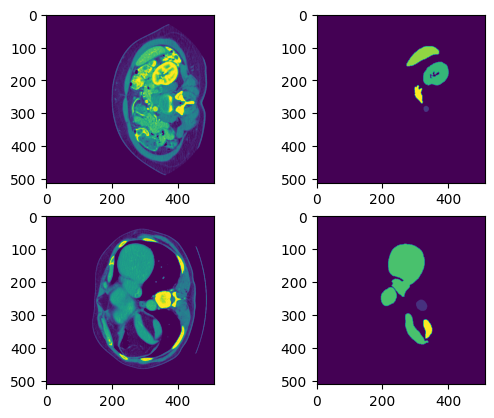

In [12]:
! ls -la ./data/BTCV.zip/project_TransUNet/data/Synapse/

data_dir = "./data/BTCV.zip/project_TransUNet/data/Synapse/train_npz/"
im_files = os.listdir(data_dir)

idx1 = random.randrange(101, len(im_files)-101)
didx1 = np.load(data_dir + im_files[idx1])
idx2 = random.randrange(101, len(im_files)-101)
didx2 = np.load(data_dir + im_files[idx2])

# we threshold all non-zero values to 1
plt.subplot(2,2,1); plt.imshow(didx1['image']);
plt.subplot(2,2,2); plt.imshow(didx1['label']);
plt.subplot(2,2,3); plt.imshow(didx2['image']);
plt.subplot(2,2,4); plt.imshow(didx2['label']);

print("\nTotal images in dataset: ", len(im_files))
np.expand_dims(didx1['image'], axis=0).shape # (c,h,w)

In [13]:
resize_transform = Compose([
    lambda sample: {
        'image': Resize((224, 224), interpolation=InterpolationMode.BILINEAR)(sample['image']),
        'masks': Resize((224, 224), interpolation=InterpolationMode.NEAREST)(sample['masks'])
    }
])

# expect masks to be binary so use nearest interpolation

In [15]:
class SegmentationDataset(Dataset):
    def __init__(self, directory, threshold=0.05, transform=resize_transform):
        self.directory = directory
        self.threshold = threshold
        self.file_list = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npz')]
        self.transform = transform

        if not self.file_list:
            raise RuntimeError(f"No .npz files found in directory: {directory}")
        else:
            print(len(self.file_list), "files were found!")
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        data = np.load(self.file_list[idx])
        image = data['image']
        masks = data['label']

        if image.ndim == 2:  # (512, 512)
            image = np.expand_dims(image, axis=0)
            masks = np.expand_dims(masks, axis=0)

        image = torch.tensor(image, dtype=torch.float32)
        masks = (masks > self.threshold).astype(np.uint8)  # Threshold to 0 or 1
        masks = torch.tensor(masks, dtype=torch.bool)
        sample = {'image': image, 'masks': masks}

        if self.transform:
            sample = self.transform(sample)

        return sample['image'], sample['masks']

## Simplified model architecture

In [16]:
class DoubleConv(nn.Module):
    def __init__(self, in_chan, out_chan):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_chan, out_chan,3,1,1,bias=False),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_chan, out_chan,3,1,1,bias=False),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [17]:
class TransUNet(nn.Module):
    def __init__(self, in_c=3, out_c=1, feats=[64, 128, 256, 512], *, trainTransformer=False):
        super(TransUNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.vit_train = trainTransformer

        for feat in feats:
            self.downs.append(DoubleConv(in_c, feat))
            in_c = feat

        for feat in reversed(feats):
            self.ups.append(nn.ConvTranspose2d(feat*2, feat, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feat*2, feat))

        self.vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)

        if (not self.vit_train):
            for param in self.vit.parameters():
                param.requires_grad = False
            self.vit.eval()

        self.vit_toproj = nn.Conv2d(feats[-1] * 2, 768, kernel_size=1)
        self.vit_deproj = nn.Conv2d(768, feats[-1] * 2, kernel_size=1)
        
        self.bottleneck = DoubleConv(feats[-1], feats[-1]*2)
        self.final_conv = nn.Conv2d(feats[0], out_c, kernel_size=1)

    
    def forward(self, x):
        if (not self.vit_train):
            self.vit.eval()
            
        skips = []

        for layer in self.downs:
            x = layer(x)
            skips.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        B, C, H, W = x.shape
        x_proj = self.vit_toproj(x)
        pos_embed = self.vit.encoder.pos_embedding[:, 1:, :]
        x_patch = x_proj.flatten(2).transpose(1, 2) + pos_embed

        if (not self.vit_train):
            with torch.no_grad():
                x_patch = self.vit.encoder.ln(self.vit.encoder.layers(x_patch))
        else:
            x_patch = self.vit.encoder.ln(self.vit.encoder.layers(x_patch))

        x = x_patch.transpose(1, 2).reshape(B, 768, H, W)
        x = self.vit_deproj(x)
        skips = skips[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)  # upsample
            skip = skips[idx//2]

            if x.shape != skip.shape:
                x = tf.resize(x, size=skip.shape[2:]) # 1,1,...

            conc = torch.cat((skip, x), dim=1)
            x = self.ups[idx+1](conc) # doubconv

        return self.final_conv(x) # scaling

In [18]:
def tunetshapetest():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )
    in_size = (2, 1, 224, 224)
    x = torch.randn(in_size).to(device)
    model = TransUNet(1, 1).to(device)
    p = model(x)
    print(x.shape)
    print(p.shape)
    print(summary(model, input_size=in_size, depth=4, col_names=["input_size", "output_size", "num_params", "trainable"]))
    del model, p, x
    torch.cuda.empty_cache()
    gc.collect()

tunetshapetest()

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 214MB/s] 


torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
TransUNet                                          [2, 1, 224, 224]          [2, 1, 224, 224]          --                        Partial
├─ModuleList: 1-7                                  --                        --                        (recursive)               True
│    └─DoubleConv: 2-1                             [2, 1, 224, 224]          [2, 64, 224, 224]         --                        True
│    │    └─Sequential: 3-1                        [2, 1, 224, 224]          [2, 64, 224, 224]         --                        True
│    │    │    └─Conv2d: 4-1                       [2, 1, 224, 224]          [2, 64, 224, 224]         576                       True
│    │    │    └─BatchNorm2d: 4-2                  [2, 64, 224, 224]         [2, 64, 224, 224]         128                       T

## Inference

In [19]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-8):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        probs = probs.view(-1)
        targets = targets.float().view(-1)

        intersection = (probs * targets).sum()
        dice = (2. * intersection + self.smooth) / (probs.sum() + targets.sum() + self.smooth)
        return 1 - dice

In [20]:
class ComboLoss(nn.Module):
    # this loss handles class imbalance properly
    def __init__(self, bce_weight=0.5, pos_weight=10.0):
        super().__init__()
        self.bce_weight = bce_weight
        if pos_weight is not None:
            if not isinstance(pos_weight, torch.Tensor):
                pos_weight = torch.tensor([pos_weight])
        self.bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        self.dice = DiceLoss()

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets.float())
        dice_loss = self.dice(logits, targets)
        return self.bce_weight * bce_loss + (1 - self.bce_weight) * dice_loss

In [23]:
data_dir = "./data/BTCV.zip/project_TransUNet/data/Synapse/train_npz/"
! mkdir -p ./checkpoints
save_dir = "./checkpoints/"

dataset = SegmentationDataset(directory=data_dir, transform=resize_transform)
train_size = int(0.8 * len(dataset)) # 80/20 split for train/test
test_size  = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

dataloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
testloader = DataLoader(testset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )

2211 files were found!


In [24]:
total_pixels = 0
total_positives = 0
for _, mask in dataset:
    total_pixels += mask.numel()
    total_positives += mask.sum().item()
imbalance_ratio = (total_pixels - total_positives) / total_positives

model = TransUNet(in_c=1, out_c=1).to(device)
criterion = ComboLoss(bce_weight=0.7, pos_weight=imbalance_ratio).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [27]:
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    total_intersection = 0.0
    total_union = 0.0
    total_correct = 0.0
    total_pixels = 0.0

    start_time = time.time()

    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.sigmoid(outputs) > 0.5

        total_correct += (preds == masks).sum().item()
        total_pixels += torch.numel(masks)

        intersection = (preds & masks).sum().item()
        union = preds.sum().item() + masks.sum().item()
        total_intersection += intersection
        total_union += union

    epoch_time = time.time() - start_time
    epoch_loss = running_loss / len(dataloader)
    accuracy = total_correct / total_pixels
    dice_score = (2 * total_intersection) / (total_union + 1e-8)

    print(f"Epoch [{epoch+1}/{num_epochs}]:")
    print(f"\tLoss: {epoch_loss:.4f}")
    print(f"\tAcc: {accuracy:.4f}")
    print(f"\tDice: {dice_score:.4f}")
    print(f"\tTime: {epoch_time:.2f} seconds")
    print("=================================")

    torch.save(model.state_dict(), os.path.join(save_dir, f'transunet_epoch_{epoch+1}.pth'))


Epoch [1/10]:
	Loss: 0.5587
	Acc: 0.9140
	Dice: 0.4982
	Time: 47.98 seconds
Epoch [2/10]:
	Loss: 0.4012
	Acc: 0.9575
	Dice: 0.6706
	Time: 47.62 seconds
Epoch [3/10]:
	Loss: 0.3136
	Acc: 0.9716
	Dice: 0.7542
	Time: 47.68 seconds
Epoch [4/10]:
	Loss: 0.2544
	Acc: 0.9777
	Dice: 0.7965
	Time: 47.66 seconds
Epoch [5/10]:
	Loss: 0.2047
	Acc: 0.9826
	Dice: 0.8340
	Time: 47.66 seconds
Epoch [6/10]:
	Loss: 0.1673
	Acc: 0.9854
	Dice: 0.8575
	Time: 47.69 seconds
Epoch [7/10]:
	Loss: 0.1567
	Acc: 0.9850
	Dice: 0.8538
	Time: 47.68 seconds
Epoch [8/10]:
	Loss: 0.1238
	Acc: 0.9884
	Dice: 0.8832
	Time: 47.68 seconds
Epoch [9/10]:
	Loss: 0.1024
	Acc: 0.9903
	Dice: 0.9009
	Time: 47.70 seconds
Epoch [10/10]:
	Loss: 0.0906
	Acc: 0.9915
	Dice: 0.9120
	Time: 47.67 seconds


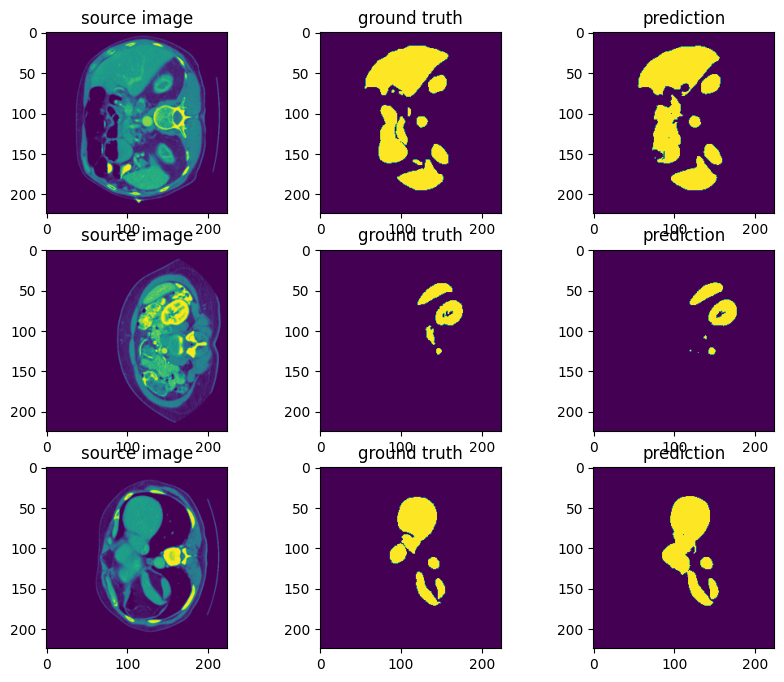

In [37]:
fig, axs = plt.subplots(3, 3, figsize=(10, 8))

def sampleEval(dataset, j=0, idx=None):
    if (not idx):
        idx = random.randrange(0, len(test_set))
    im = dataset[idx][0].to(device)
    lb = dataset[idx][1].to(device)
    pr = (torch.sigmoid(model(im.unsqueeze(0))) > 0.5).cpu().numpy()[0,0]

    axs[j,0].imshow(im[0].cpu().numpy()); axs[j,0].set_title("source image")
    axs[j,1].imshow(lb[0].cpu().numpy()); axs[j,1].set_title("ground truth")
    axs[j,2].imshow(pr); axs[j,2].set_title("prediction")

sampleEval(testset)
sampleEval(dataset, 1, idx1)
sampleEval(dataset, 2, idx2)

In [38]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_pixels = 0
    total_intersection = 0.0
    total_union = 0.0

    start_time = time.time()

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            targets = masks > 0.5

            total_correct += (preds == targets).sum().item()
            total_pixels += torch.numel(targets)

            total_intersection += (preds & targets).sum().item()
            total_union += preds.sum().item() + targets.sum().item()

    epoch_time = time.time() - start_time
    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_pixels
    dice_score = (2 * total_intersection) / (total_union + 1e-8)

    print("Test Set Evaluation:")
    print(f"Loss     : {avg_loss:.4f}")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Dice     : {dice_score:.4f}")
    print(f"Time: {epoch_time:.2f} seconds")


testcriterion = ComboLoss(bce_weight=0.7, pos_weight=imbalance_ratio).to(device)
evaluate(model, testloader, testcriterion, device)

Test Set Evaluation:
Loss     : 0.1886
Accuracy : 0.9936
Dice     : 0.9213
Time: 6.32 seconds
